__NAME:__ __Nigel Mansell__  
__SECTION #:__ __995__  
__CS 5970: Machine Learning Practices__

# Homework 4: Linear Regression

## Assignment Overview
Follow the TODOs and read through and understand any provided code.  
For all plots, make sure all necessary axes and curves are clearly and 
accurately labeled. Include figure/plot titles appropriately as well.

### Task
For this assignment you will work with different training set sizes, constructing
regression models from these sets, and evaluating the training and test performance
of these models. Additionally, it is good practice to have a high level understanding
of the data one is working with, thus upon loading the data, general information is 
also displayed and/or plotted.

### Data set
The BMI (Brain Machine Interface) data consists of several files prefixed with 'MI', 
'theta', 'dtheta', 'torque', or 'time'.  
* _MI_ files contain data with the number of spikes for 48 neurons, in mutliple 
time bins, for a single fold. There are 20 folds (20 files), where each fold consists 
of over 1000 times points, or samples (the rows). At each time point, we record the number of 
spikes for each neuron for 20 bins. Therefore, each time point has 48 * 20 = 960 
columns.  
* _theta_ files record the angular position of the shoulder (in column 0) and the elbow 
(in column 1) for each time point.  
* _dtheta_ files record the angular velocity of the shoulder (in column 0) and the elbow 
(in column 1) for each time point.  
* _torque_ files record the torque of the shoulder (in column 0) and the elbow (in column 
1) for each time point.  
* _time_ files record the actual time stamp of each time point.  

A fold is a subset of the available data.  Cutting the data into folds is useful for adjusting training, validation, and test 
sets sizes, and for assessing the generality of a modelling approach.  Each fold contains independent time points.

This assignment uses code examples and concepts from the lectures on regression 

### Objectives
* Understand the impact of the training set size
* Understand the essentials of linear regression:
  + Prediction
  + Multiple Regression
  + Performance Evaluation

### Notes
* Do not save work within the ml_practices folder
  + create a folder in your home directory for assignments, and copy the templates there  

### General References
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Sci-kit Leatn Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [Torque](https://en.wikipedia.org/wiki/Torque)

### Hand-In Procedure
* Execute all cells so they are showing correct results
* Notebook:
  + Submit this file (.ipynb) to the Canvas HW4 dropbox
* PDF:
  + File/Print/Print to file -> Produces a copy of the notebook in PDF format
  + Submit the PDF file to the Gradescope HW4 dropbox

In [54]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os, re, fnmatch
import matplotlib.pyplot as plt
import matplotlib.patheffects as peffects

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

FIGWIDTH = 5
FIGHEIGHT = 5
FONTSIZE = 12

plt.rcParams['figure.figsize'] = (FIGWIDTH, FIGHEIGHT)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline

# LOAD DATA

In [55]:
""" PROVIDED """
def read_bmi_file_set(directory, filebase):
    '''
    Read a set of CSV files and append them together
    :param directory: The directory in which to scan for the CSV files
    :param filebase: A file specification that potentially includes wildcards
    :returns: A list of Numpy arrays (one for each fold)
    '''
    
    # The set of files in the directory
    files = fnmatch.filter(os.listdir(directory), filebase)
    files.sort()

    # Create a list of Pandas objects; each from a file in the directory that matches filebase
    lst = [pd.read_csv(directory + "/" + file, delim_whitespace=True,).values for file in files]
    
    # Concatenate the Pandas objects together.  ignore_index is critical here so that
    # the duplicate row indices are addressed
    return lst

In [56]:
""" TODO
Load the BMI data from all the folds, using read_bmi_file_set()
"""

# may need to adjust the filepath if you are not working on Oscer
dir_name = '/home/nigel/Desktop/mlp/mlp_2020/datasets/bmi/DAT6_08'

# TODO: finish loading the MI data folds

#loaded MI_folds
MI_folds = read_bmi_file_set(dir_name, 'MI_fold*')
theta_folds = read_bmi_file_set(dir_name, 'theta_fold*')
dtheta_folds = read_bmi_file_set(dir_name, 'dtheta_fold*')
torque_folds = read_bmi_file_set(dir_name, 'torque_fold*')
time_folds = read_bmi_file_set(dir_name, 'time_fold*')

alldata_folds = zip(MI_folds, theta_folds, dtheta_folds, torque_folds, time_folds)

nfolds = len(MI_folds)
nfolds

20

In [57]:
""" TODO
Print out the shape of all the data for each fold
"""
# TODO: finish by including shape of time data

#called shape on the appropiate data
for i, (MI, theta, dtheta, torque, time) in enumerate(alldata_folds):
    print("FOLD %2d " % i, MI.shape, theta.shape, 
          dtheta.shape, torque.shape, time.shape) # TODO

FOLD  0  (1193, 960) (1193, 2) (1193, 2) (1193, 2) (1193, 1)
FOLD  1  (1104, 960) (1104, 2) (1104, 2) (1104, 2) (1104, 1)
FOLD  2  (1531, 960) (1531, 2) (1531, 2) (1531, 2) (1531, 1)
FOLD  3  (1265, 960) (1265, 2) (1265, 2) (1265, 2) (1265, 1)
FOLD  4  (1498, 960) (1498, 2) (1498, 2) (1498, 2) (1498, 1)
FOLD  5  (1252, 960) (1252, 2) (1252, 2) (1252, 2) (1252, 1)
FOLD  6  (1375, 960) (1375, 2) (1375, 2) (1375, 2) (1375, 1)
FOLD  7  (1130, 960) (1130, 2) (1130, 2) (1130, 2) (1130, 1)
FOLD  8  (1247, 960) (1247, 2) (1247, 2) (1247, 2) (1247, 1)
FOLD  9  (1257, 960) (1257, 2) (1257, 2) (1257, 2) (1257, 1)
FOLD 10  (1265, 960) (1265, 2) (1265, 2) (1265, 2) (1265, 1)
FOLD 11  (1146, 960) (1146, 2) (1146, 2) (1146, 2) (1146, 1)
FOLD 12  (1225, 960) (1225, 2) (1225, 2) (1225, 2) (1225, 1)
FOLD 13  (1238, 960) (1238, 2) (1238, 2) (1238, 2) (1238, 1)
FOLD 14  (1570, 960) (1570, 2) (1570, 2) (1570, 2) (1570, 1)
FOLD 15  (1359, 960) (1359, 2) (1359, 2) (1359, 2) (1359, 1)
FOLD 16  (1579, 960) (15

In [58]:
""" PROVIDED
Print out the first few rows and columns of the MI data
for a few folds
"""
for i, MI in enumerate(MI_folds[:3]):
    print("FOLD %2d" % i)
    print(MI[:5,:20])

FOLD  0
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
FOLD  1
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]
FOLD  2
[[0 0 0 0 0 1 0 1 2 1 0 0 1 0 0 0 1 2 0 0]
 [0 0 0 0 1 0 1 2 1 0 0 1 0 0 0 1 2 0 0 0]
 [0 0 0 1 0 1 2 1 0 0 1 0 0 0 1 2 0 0 0 0]
 [0 0 1 0 1 2 1 0 0 1 0 0 0 1 2 0 0 0 0 0]
 [0 1 0 1 2 1 0 0 1 0 0 0 1 2 0 0 0 0 0 0]]


In [59]:
""" TODO
Check the data for any NaNs
"""
def anynans(X):
    return np.isnan(X).any()

alldata_folds = zip(MI_folds, theta_folds, dtheta_folds, torque_folds, time_folds)

# TODO: finish by checking the MI data for any NaNs

#checked MI data for NaNs
for i, (MI, theta, dtheta, torque, time) in enumerate(alldata_folds):
    print("FOLD %2d " % i, anynans(MI), anynans(theta), # TODO
          anynans(dtheta), anynans(torque), anynans(time))

FOLD  0  False False False False False
FOLD  1  False False False False False
FOLD  2  False False False False False
FOLD  3  False False False False False
FOLD  4  False False False False False
FOLD  5  False False False False False
FOLD  6  False False False False False
FOLD  7  False False False False False
FOLD  8  False False False False False
FOLD  9  False False False False False
FOLD 10  False False False False False
FOLD 11  False False False False False
FOLD 12  False False False False False
FOLD 13  False False False False False
FOLD 14  False False False False False
FOLD 15  False False False False False
FOLD 16  False False False False False
FOLD 17  False False False False False
FOLD 18  False False False False False
FOLD 19  False False False False False


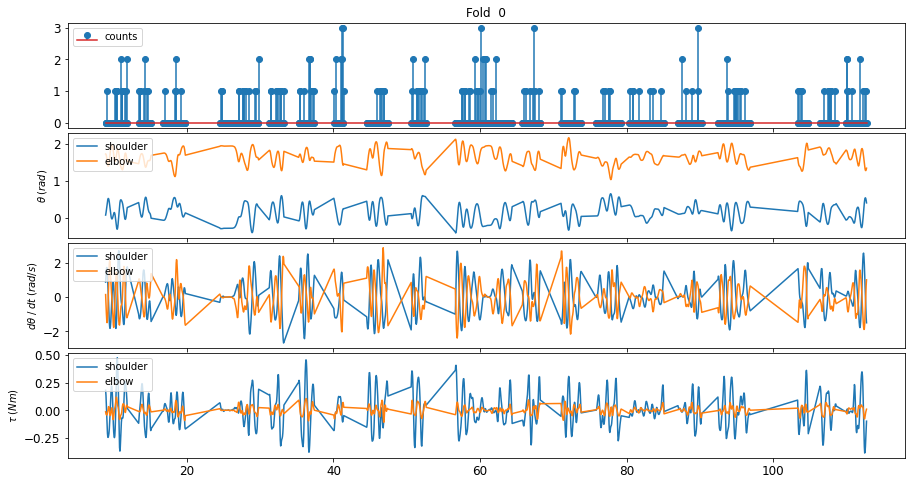

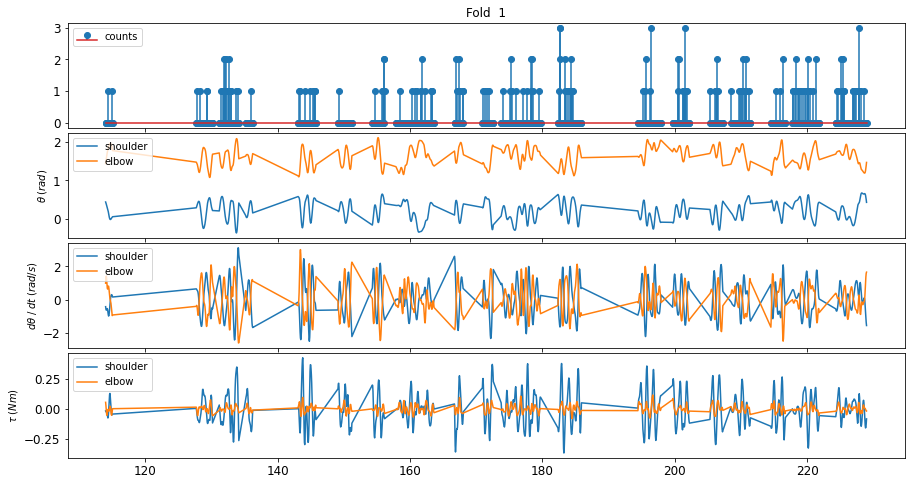

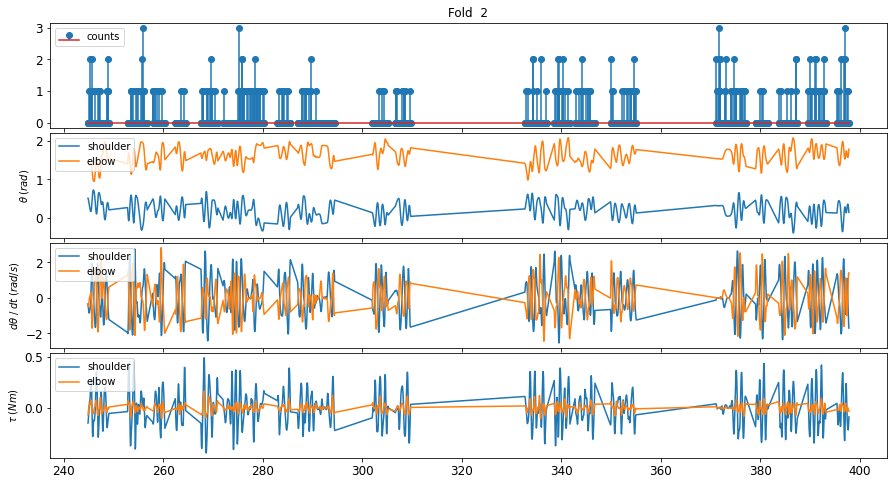

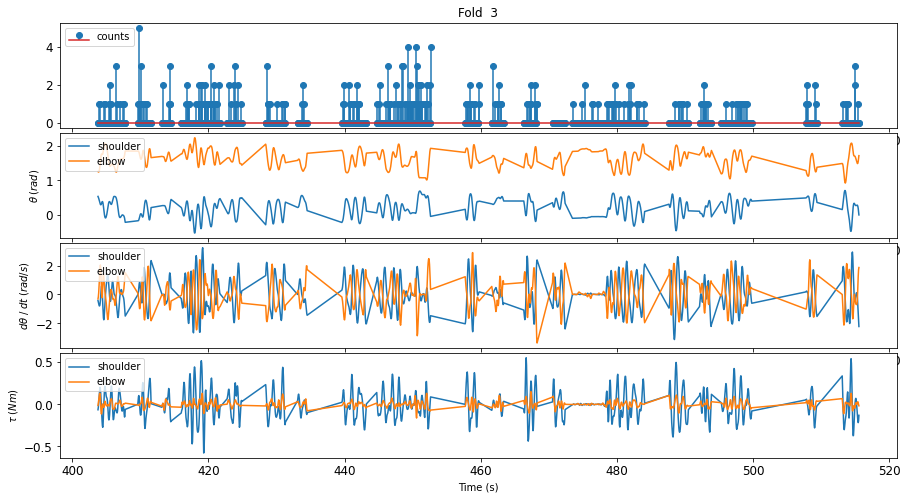

In [60]:
""" PROVIDED
For several folds, plot the data for the elbow and shoulder
and from one neuron
"""
f = 4
data_folds = zip(MI_folds[:f], theta_folds[:f], dtheta_folds[:f], 
                 torque_folds[:f], time_folds[:f])

for i, (MI, theta, dtheta, torque, time) in enumerate(data_folds):
    fig, axs = plt.subplots(4, 1, figsize=(FIGWIDTH*3,8))
    fig.subplots_adjust(hspace=.05)
    axs = axs.ravel()
    
    # Neural Activation Counts
    axs[0].stem(time, MI[:,0], label='counts')
    axs[0].set_title("Fold %2d" % i)
    axs[0].legend(loc='upper left')
    
    lgnd = ['shoulder', 'elbow']
    
    # Position
    axs[1].plot(time, theta)
    axs[1].set_ylabel(r"$\theta \;(rad)$")
    axs[1].legend(lgnd, loc='upper left')
    
    # Velocity
    axs[2].plot(time, dtheta)
    axs[2].set_ylabel(r"$d\theta\; /\; dt \;(rad/s)$")
    axs[2].legend(lgnd, loc='upper left')
    
    # Torque
    axs[3].plot(time, torque)
    axs[3].set_ylabel(r"$\tau \;(Nm)$")
    axs[3].legend(lgnd, loc='upper left')
    if i == (f-1): 
        axs[3].set_xlabel('Time (s)')

# MODEL OUTPUTS

Text(0.5, 1.0, '$\\tau \\;(Nm)$')

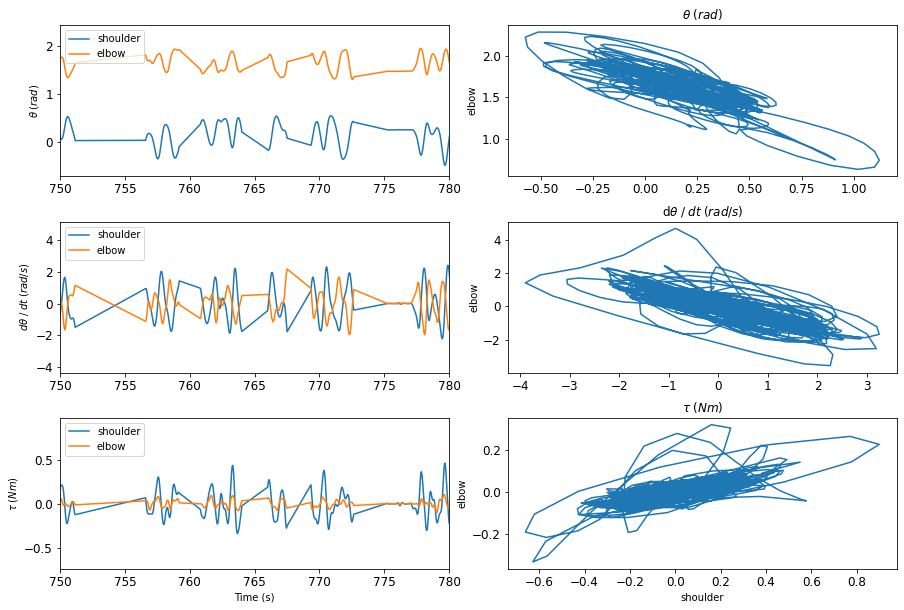

In [61]:
""" PROVIDED
For the sixth fold, visualize the correlation between the shoulder
and elbow for the angular position, the angular velocity, and the 
torque
"""
f = 5

y_pos = theta_folds[f]
y_vel = dtheta_folds[f]
y_tor = torque_folds[f]
time = time_folds[f]

nrows = 3
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(FIGWIDTH*3,FIGHEIGHT*2))
fig.subplots_adjust(wspace=.15, hspace=.3)
axs = axs.ravel()
xlim = [750, 780]

# POSITION
p = 0
axs[p].plot(time, y_pos)
axs[p].set_ylabel(r'$\theta \;(rad)$')
#axs[p].set_title(r'$\theta \;(rad)$')
axs[p].legend(['shoulder', 'elbow'], loc='upper left')
axs[p].set_xlim(xlim)

p = 1
axs[p].plot(y_pos[:,0], y_pos[:,1])
axs[p].set_ylabel('elbow')
axs[p].set_title(r'$\theta \; (rad)$')

# VELOCITY
p = 2
axs[p].plot(time, y_vel)
axs[p].set_ylabel(r'$d\theta\;/\;dt\;(rad/s)$')
#axs[p].set_title(r'$d\theta\;/\;dt\;(rad/s)$')
axs[p].legend(['shoulder', 'elbow'], loc='upper left')
axs[p].set_xlim(xlim)

p = 3
axs[p].plot(y_vel[:,0], y_vel[:,1])
axs[p].set_ylabel('elbow')
axs[p].set_title(r'd$\theta\;/\;dt\;(rad/s)$')

# TORQUE
p = 4
axs[p].plot(time, y_tor)
axs[p].set_ylabel(r'$\tau \;(Nm)$')
#axs[p].set_title(r'$\tau$')
axs[p].legend(['shoulder', 'elbow'], loc='upper left')
axs[p].set_xlabel('Time (s)')
axs[p].set_xlim(xlim)

p = 5
axs[p].plot(y_tor[:,0], y_tor[:,1])
axs[p].set_xlabel('shoulder')
axs[p].set_ylabel('elbow')
axs[p].set_title(r'$\tau \;(Nm)$')

# REGRESSION
Predict torque of the shoulder and the elbow from the neural activations

In [62]:
""" TODO
Evaluate the training performance of an already trained model
"""
def mse_rmse(trues, preds):
    '''
    Compute MSE and rMSE for each column separately.
    '''
    mse = np.sum(np.square(trues - preds), axis=0) / trues.shape[0]
    rmse_rads = np.sqrt(mse)
    rmse_degs = rmse_rads * 180 / np.pi
    return mse, rmse_rads, np.reshape(rmse_degs, (1, -1))

# TODO: finish implementation
def predict_score_eval(model, X, y):
    '''
    Compute the model predictions and corresponding scores.
    PARAMS:
        model: the trained model used to make predicitons
        X: feature data
        y: corresponding output
    RETURNS:
        mse: mean squared error for each column
        rmse_rads: rMSE in radians
        rmse_deg: rMSE in degrees
        score: score computed by the models score() method
        preds: predictions of the model from X
    '''
    
    # TODO: use the model to predict the outputs from the input data
    
    #calling the api predict
    preds = model.predict(X)
    # TODO: use the model to compute the score 
    
    #calling the api score
    score = model.score(X,y)
    # for the LinearRegression model, this is the coefficient of determination: R^2
    # see the Sci-kit Learn documentation for LinearRegression for more details
    
    #setting the variables to the return value of the mse_rmse functino, passing trues and preds
    mse, rmse_rads, rmse_deg = mse_rmse(y, preds)
    # TODO: use mse_rmse() to compute the mse and rmse
    
    #returning variables from above
    return mse, rmse_rads, rmse_deg, score, preds


### Training

In [63]:
""" TODO
Extract the MI data from fold 5 as input and the torque data from 
fold 5 as the output, for a multiple linear regression model (i.e.
the model will simultaneously predict shoulder and elbow torque).
Create a LinearRegression() model and train it using fit() on the 
data from fold 5
"""
fold_idx = 5

#setting X to MI_folds, y to torque_folds, and time to time_folds using fold_idx
X = MI_folds[fold_idx]

y = torque_folds[fold_idx]

time = time_folds[fold_idx]


model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [64]:
""" TODO
Evaluate the training performace of the model, using predict_score_eval()
Print the results displaying MSE, rMSE in rads and degrees, and the 
correlation
"""
# TODO: call predict_score_eval() and get the corresponding outputs

#setting variables to the return values of the predict_score_eval()
mse, rmse_rads, rmse_deg, score, preds = predict_score_eval(model, X, y)

# TODO: print the results of predict_score_eval()

#printing the variables
print(mse, rmse_rads, rmse_deg, score, preds)

[0.0016154  0.00023508] [0.04019205 0.01533239] [[2.30283461 0.87848135]] 0.9362666857422082 [[-0.02121785  0.01745515]
 [-0.0483844   0.00708094]
 [-0.00317419 -0.00564707]
 ...
 [-0.04346495 -0.00914585]
 [-0.09447689 -0.01704347]
 [-0.13216702 -0.01524937]]


(750.0, 780.0)

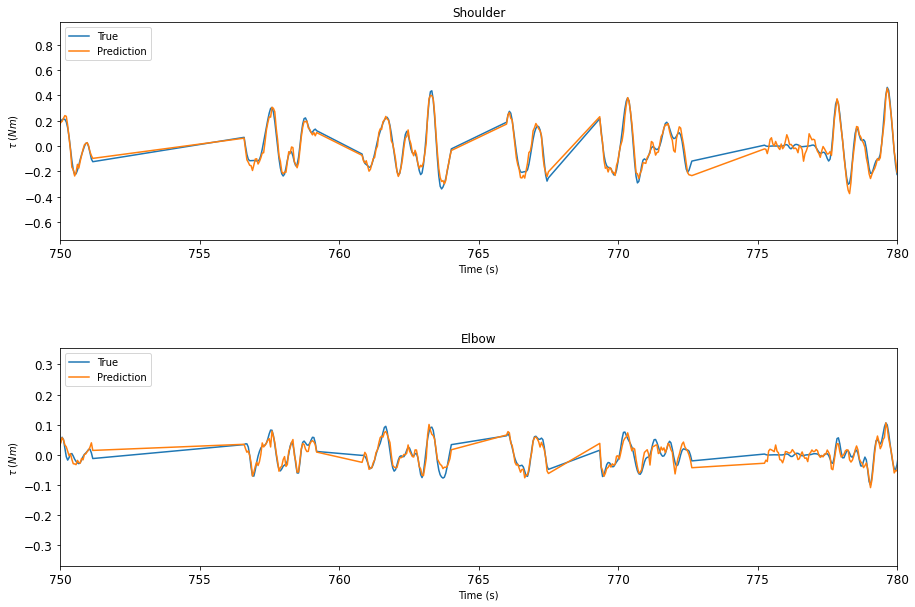

In [65]:
""" TODO
Plot the true torque and the predicted torque for the shoulder and 
elbow, over time. Use 2 subplots (one subplot per output).

Focus on the time range 750 to 780 seconds
"""
titles = ['Shoulder', 'Elbow']
#setting xlim to 750, 780
xlim = ([750, 780])

# TODO: Generate the plots

#plotting the data
legends = ['True', 'Prediction']
fig, axs = plt.subplots(2, figsize=(FIGWIDTH*3,FIGHEIGHT*2))
fig.subplots_adjust(wspace=.15, hspace=.5)
axs[0].set_title('Shoulder')
axs[0].plot(time, y[:,0])
axs[0].plot(time, preds[:,0])
axs[0].legend(legends, loc='upper left')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel(r'$\tau \;(Nm)$')
axs[0].set_xlim(xlim)
axs[1].set_title('Elbow')
axs[1].plot(time, y[:,1])
axs[1].plot(time, preds[:,1])
axs[1].legend(legends, loc='upper left')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel(r'$\tau \;(Nm)$')
axs[1].set_xlim(xlim)

### Testing

In [66]:
""" TODO
Evaluate the performace of the model on unseen data from fold 1.
Recall that your model was trained using data from fold 5.
Print the results displaying MSE, rMSE in rads and degrees, and 
the correlation
"""
fold_idx = 1

#setting Xtest, ytest and time_tst
Xtest = MI_folds[fold_idx]
ytest = torque_folds[fold_idx]
time_tst = time_folds[fold_idx]


# TODO: call predict_score_eval() and get the corresponding outputs

#setting variables to the return value of predict_score_eval()
mse, rmse_rads, rmse_deg, score, preds = predict_score_eval(model, Xtest, ytest)

# TODO: print the results of predict_score_eval()

#printing above variables
print(mse, rmse_rads, rmse_deg, score, preds)

[0.03178992 0.00421368] [0.17829727 0.06491284] [[10.21568095  3.7192317 ]] -1.8294538460375969 [[ 0.01705051 -0.01002633]
 [ 0.09071857  0.00101667]
 [ 0.07183283 -0.06066337]
 ...
 [-0.20246063 -0.03309132]
 [-0.08541131  0.00544795]
 [ 0.06796495 -0.01787921]]


(170.0, 180.0)

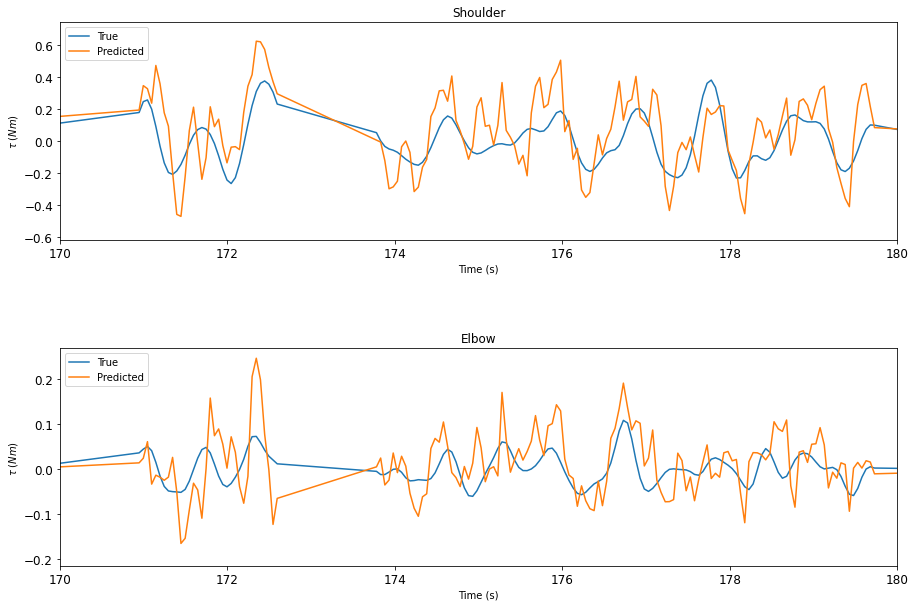

In [67]:
""" TODO
Plot the true torque and the predicted torque over time, for the 
shoulder and the elbow. Use 2 subplots (one for the shoulder and 
the other for the elbow)

Focus on the time range 170 to 180 seconds
"""
titles = ['Shoulder', 'Elbow']
#setting xlim
xlim = [170, 180]

# TODO: Generate the plots

#plotting data
legends = ['True', 'Predicted']
fig, axs = plt.subplots(2, figsize=(FIGWIDTH*3,FIGHEIGHT*2))
fig.subplots_adjust(wspace=.15, hspace=.5)
axs[0].set_title('Shoulder')
axs[0].plot(time_tst, ytest[:,0])
axs[0].plot(time_tst, preds[:,0])
axs[0].legend(legends, loc='upper left')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel(r'$\tau \;(Nm)$')
axs[0].set_xlim(xlim)
axs[1].set_title('Elbow')
axs[1].plot(time_tst, ytest[:,1])
axs[1].plot(time_tst, preds[:,1])
axs[1].legend(legends, loc='upper left')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel(r'$\tau \;(Nm)$')
axs[1].set_xlim(xlim)

### Training Size Sensitivity
For this section, you will be training the model on a different number of folds, each time testing it on the same unseen data from another fold not used in the training procedure.

In [68]:
""" TODO
Fill in the missing lines of code
"""
def training_set_size_loop(model, X, y, folds_inds, val_fold_idx):
    '''
    Train a model on multiple training set sizes
    
    PARAMS:
        model: object to train
        X: input data
        y: output data
        folds_inds: list of the fold indices to use for different 
                    training sets
        val_fold_idx: fold index to use as the validation set
    RETURNS:
        rmse: dict of train and validation RMSE lists
        corr: dict of train and validation R^2 lists
    '''
    # Initialize log of performance metrics
    ncats = y[0].shape[1]
    rmse = {'train':np.empty((0, ncats)), 'val':np.empty((0, ncats))}
    corr = {'train':[], 'val':[]}
    
    # Data used for validation
    Xval = X[val_fold_idx]
    yval = y[val_fold_idx]
    
    # Loop over the different experiments
    for f in folds_inds:
        # Construct training set 
        Xtrain = np.concatenate(X[:f])
        ytrain = np.concatenate(y[:f])
        
        # Build the model
        model.fit(Xtrain, ytrain)
        
        # TODO: call predict_score_eval using the training data
        
        #setting training variables to the return values of predict_score_eval
        mse, rmse_rads, rmse_degs, score, preds = predict_score_eval(model, Xtrain, ytrain)
        # TODO: call predict_score_eval using the validation data
        
        #setting validtaion variables to the return values of predict_score_eval
        mse_val, rmse_rads_val, rmse_degs_val, score_val, preds_val = predict_score_eval(model, Xval, yval)

        # Record the performance metrics for this experiment
        rmse['train'] = np.append(rmse['train'], rmse_degs, axis=0)
        corr['train'].append(score)
        rmse['val'] = np.append(rmse['val'], rmse_degs_val, axis=0)
        corr['val'].append(score_val)
        
    return rmse, corr

In [69]:
""" TODO 
Create a new linear model and train the model on different training set sizes, 
using training_set_size_loop() with training set sizes of folds 1 through 17 
and use 18 as the val_fold_idx.
The input data is the MI data and the output data is the torque for both the 
shoulder and elbow.
""" 
val_fold = 18
folds = range(1, val_fold)

# TODO: Create a new LinearRegression model

#setting X, y  and model
X = MI_folds
y = torque_folds
model = LinearRegression()

# TODO: get the list of rMSE and correlation values per training set size, by
#       using training_set_size_loop 

#setting variables to the return variables of training_set_size_loop
rmse, corr = training_set_size_loop(model, X, y, folds, val_fold)

Text(0, 0.5, 'Value')

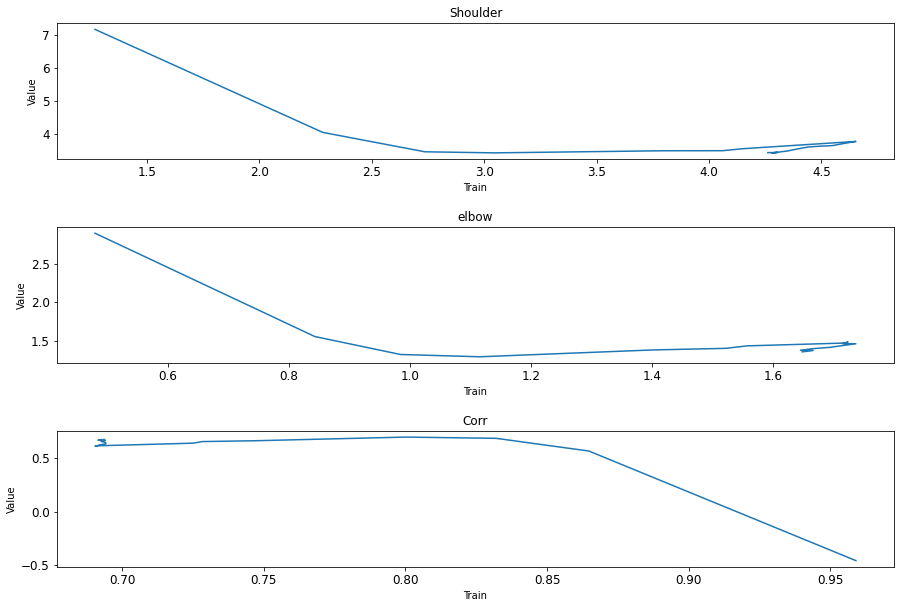

In [70]:
""" TODO
Plot rMSE as a function of the training set size for
the shoulder and the elbow; also plot correlation as
a function of training set size. Use three subplots
(one for the shoulder rMSE, one for the elbow rMSE, and
one with the correlation)
"""

#plotting the data
fig, axs = plt.subplots(3, figsize=(FIGWIDTH*3,FIGHEIGHT*2))
fig.subplots_adjust(wspace=.15, hspace=.5)
axs[0].plot(rmse['train'][:,0],rmse['val'][:,0])
axs[0].set_xlabel('Train')
axs[0].set_ylabel('Value')
axs[0].set_title('Shoulder')
axs[1].plot(rmse['train'][:,1],rmse['val'][:,1])
axs[1].set_title('elbow')
axs[1].set_xlabel('Train')
axs[1].set_ylabel('Value')
axs[2].plot(corr['train'], corr['val'])
axs[2].set_title('Corr')
axs[2].set_xlabel('Train')
axs[2].set_ylabel('Value')